## Self-supervised learning

### Why self-supervised learning in robotics
Normally, when thinking of 'learning robots', one thinks of reinforcement learning or imitation learning - both learning settings in which robots attempt to directly learn better control policies. A more recent form of learning, which typically involves the learning of perceptual abilities, is _self-supervised learning_ (SSL). 

A self-supervised learning robot provides its own supervised learning targets. This seems strange at first: Why would a robot want to learn what it already knows?

The best example to illustrate why SSL is useful, is perhaps also the most famous and one of the first robots to use SSL: The robot 'Stanley' used SSL to win the DARPA Grand Challenge in 2005 [1]. In that challenge, autonomously driving cars had to drive a 212 km long, off-road course, as fast as possible. Stanley's programs consisted of a lot of impressive elements, but one of the most important and interesting ones was the use of SSL for looking further ahead. The SSL scheme was set up as follows: Stanley could use its LiDAR measurements to reliably detect whether the ground ahead consisted of drivable terrain (road) or not. However, the range of the LiDAR measurements was limited. In contrast to the LiDAR, Stanley's cameras could see the ground and terrain also at very large ranges. This led to the following learning setup: at the close distances, LiDAR provided supervised training for a vision algorithm that learned a mapping from visual appearance (color, texture) to terrain labels (drivable / non-drivable). Then, the vision algorithm could be applied to areas higher up in the image, beyond the LiDAR range. 

This self-supervised learning setup allowed Stanley to detect the road further ahead, speed up, and win the race (by 11 minutes on the 212km track!).

<IMG SRC="Stanley2.JPG" WIDTH="50%" ALT="An official DARPA photograph of Stanley at the 2005 DARPA Grand Challenge. Stanley, created by the Stanford University Racing Team, won the race and the 2 million US dollar prize. This photograph was found at http://www.darpa.mil/grandchallenge05/high_res"></IMG>
<CENTER>*Figure 1:* The robot 'Stanley' that won the 2005 DARPA Grand Challenge, partially thanks to self-supervised learning. </CENTER>

Another way of self-supervised learning generates the targets from input data. For instance, in [2] an algorithm was proposed that allows to learn monocular depth estimation based on stereo vision images. The idea is illustrated in Figure 2 below. A deep neural network maps a single image (the left image from the stereo pair) to a depth map. The known geometry from the stereo vision setup, allows the algorithm to warp the left image with the depth map to the expected right image. The expected right image is compared to the actual right image, with the difference between these images termed the reconstruction error. This reconstruction error can be backpropagated to first obtain errors for the depth map and then for the weights in the deep neural network, allowing to adjust the weights so that the reconstruction error is minimal. In this way, the algorithm is able to learn monocular depth estimation without any human or other supervision. After [2], many other studies have elaborated on this core idea, and now self-supervised learning is the main way of learning monocular depth estimation.

<IMG SRC="idea_SSL_depth.png" WIDTH="80%" ALT="Idea behind Garg's monocular depth estimation algorithm. Open access image from https://github.com/Ravi-Garg/Unsupervised_Depth_Estimation/blob/master/idea.png"></IMG>
<CENTER>*Figure 2:* The idea behind self-supervised learning of monocular depth estimation. </CENTER>

### Definition of self-supervised learning
Supervised learning is one of the major problem settings within machine learning. 

*Definition:* _"Supervised learning is the machine learning task of learning a function that maps an input to an output based on example input-output pairs."_ (From <A HREF="https://en.wikipedia.org/wiki/Supervised_learning" TARGET="_blank">Wikipedia</A>)

_Self-supervised learning_ (SSL) is a newer, less known form of machine learning and hence its definition is also less established. In fact, SSL is a subset of supervised learning, which sets a restriction on how the example input-output pairs are obtained. That is, these example pairs are not determined by a human, but are self-generated.

*Definition:* _"Self-supervised learning is a type of supervised learning where the training labels are determined by the input data."_ (From <A HREF="https://machinelearning.wtf/terms/self-supervised-learning/" TARGET="_blank">Machine Learning Glossary</A>)

From a robotics stand point, the defition could be:

*Definition:* _"Self-supervised learning is a type of supervised learning where the training labels are generated by the robot itself."_ 

From a machine learning stand point, self-supervised learning is equal to supervised learning. This means that the methods and principles for supervised are also applicable to self-supervised learning. Hence, one can wonder whether it is useful to make a distinction between supervised learning and SSL. 

The main property of SSL is that the self-supervised setup allows for the generation of large numbers of training examples, without any human effort. This is a huge advantage for deep learning methods, which perform much better when ample training data is available. Of course, the automated generation of training examples has consequences on the problem setting. For example, in a robotic scenario, training examples will come continuously from the robot's sensors. This means that these examples are typically statistically dependent on each other. This goes in against the typical assumption of _independent, identically distributed_ (i.i.d.) samples. Moreover, training examples are not verified by a human, so the training set could contain more wrong examples or more noise than in a typical, human-made training set.

## Case study: learning to estimate height
In this notebook, you will study a very simple case of self-supervised learning, introduced in [3]. A drone has two sensors that are supposed to capture height: a sonar and a barometer. Normally, one would convert the measured pressure to meters, using the pressure at startup for a 0-meter calibration. Then, one would characterize both sensors in terms of how accurate they are, and fuse the measurements to obtain a height estimate. 

However, in this SSL case study, we will assume that we only know of the sonar what its relation is to height in meters. We will then try to learn to predict the sonar measurements by means of pressure measurements. After learning, the drone can also use the barometer for height estimation. What is special about this case study is that, in contrast to most work on SSL, we will fuse the height estimate from the barometer back with the sonar measurement and see whether the fused estimate is better than sonar alone. In order to determine which is better, we compare the fused estimates with highly accurate motion tracking system estimates (in our case Optitrack). The overview of the learning setup is shown in Figure 3.

<IMG SRC="overview_fusion.png" WIDTH="60%"></IMG>

<CENTER> <I>Figure 3:</I> Overview of the self-supervised learning fusion setup studied in [3] and this notebook. </CENTER>

<FONT COLOR="red">Exercise 1.</FONT>

1. Run the cell below to have a look at the data. It imports the Python file <A HREF="SSL_drone_data.py" TARGET="_blank">SSL_drone_data.py</A>, loads and plots the data. The first plot shows $h_{\textrm{sonar}}$, $h_{\textrm{pressure}}$, and $h_{\textrm{Optitrack}}$. To obtain $h_{\textrm{pressure}}$, we make use of the formula that relates pressure to height (<A HREF="https://en.wikipedia.org/wiki/Barometric_formula" TARGET="_blank">Wikipedia</A>). Please make your own code to map the pressure measurement to height. 

2. Compare the pressure-based height estimate with the height from Optitrack. What is the main problem in mapping pressure to height?

3. Compare the sonar height with optitrack. How accurate is it? Does the sonar measurement seem to be a biased estimate of the height?

Text(0, 0.5, 'Pressure [Pa]')

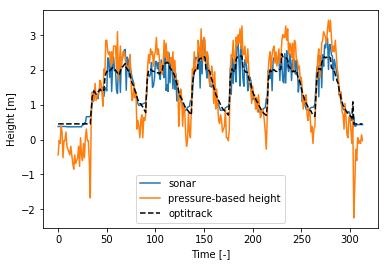

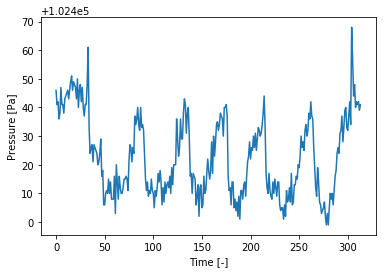

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
import SSL_drone_data as SSL
import numpy as np

# drone_data is a dict with the following keys:
# 'pressure', 'sonar', and 'optitrack'
drone_data = SSL.get_drone_data()
SSL.plot_drone_data(drone_data)

# plot the pressure
plt.figure()
plt.plot(drone_data['pressure'])
plt.xlabel('Time [-]')
plt.ylabel('Pressure [Pa]')

# 1.1. Make your code to map pressure (drone_data['pressure']) to height in meters

# 1.2. Compare the pressure-based height estimate with the height from Optitrack (drone_data['optitrack'])

# 1.3. Compare the sonar height (drone_data['sonar']) with optitrack


### Data fusion
A standard approach to the data fusion of two sensors is to determine the accuracy of both sensors with respect to the target value $t$ they are trying to measure, and fuse them accordingly. When not knowing anything about the distribution of the target value, and assuming the measurements to be normally distributed around the target value, we get the following equation for fusing two sensors (see, e.g., <A HREF="https://en.wikipedia.org/wiki/Sensor_fusion" TARGET="_blank">the Wikipedia entry on sensor fusion</A>):

$\hat{t} = \frac{\frac{1}{\sigma_1^2} x_1 + \frac{1}{\sigma_2^2} x_2}{\frac{1}{\sigma_1^2} +  \frac{1}{\sigma_2^2}} = \frac{\sigma_2^2 x_1 + \sigma_1^2 x_2}{\sigma_1^2 + \sigma_2^2}$,

where $x_1$ and $x_2$ are weighed by the inverse of their variance. If we assume that we know the distribution of the target value, we can incorporate this information into the formula:

$\hat{t} = \frac{\sigma_2^2 x_1 + \sigma_1^2 x_2}{\sigma_1^2 + \sigma_2^2 + \sigma_t^2}$,

as shown in, e.g., [4]. The figure below shows a model (a), which corresponds to such a typical setting, in which we assume we know the distributions of $t$, $x_1$ and $x_2$. We want to estimate the unknown, latent variable $t$, which is hence grey in the figure. 

<IMG SRC="model.png" WIDTH="60%"></IMG>

<CENTER> <I>Figure 4:</I> Probabilistic models underlying the self-supervised learning fusion setup studied in [3] and this notebook. (a) Typical model in which the robot 'knows' all distributions and has to estimate the latent variable $t$ (in grey). (b) The model from the robot's viewpoint, showing its lack of knowledge. The dashed lines indicate that the robot does not know the distributions of $t$ and $P$. (c) The robot will assume it does know the distribution of the learned cue $x_p$, so that it can be fused with $x_s$.</CENTER>

The self-supervised learning setup is special, though. Let us assume a scenario in which the robot knows the accuracy of the sonar $x_s$, which it considers as an unbiased estimator, normally distributed around $t$ (the height). That is, the robot knows $\sigma_s^2$. The robot neither knows the distribution of $t$, nor knows anything about the pressure $P$. This situation is illustrated in part (b) of the figure above, where dashed lines indicate the absence of knowledge about the distribution. 

Still, the robot will try to map $P$ to $x_s$, which it will assume to result in an unbiased estimator, $x_p$, which is also normally distributed around $t$, as illustrated in part (c) of the figure. Of course, the robot does not know $t$. It will estimate the accuracy of $x_p$ (its variance around $t$) by measuring its variance around the sonar value $x_s$, $\sigma_p^2$.

<FONT COLOR="red">Exercise 2.</FONT>

1. Below you will find code to learn a mapping from pressure measurements $p$ to sonar measurements $x_s$. It also shows the distribution of $x_p$ around $x_s$. Please write the code to estimate the variance $\sigma_p^2$ (using the training set) and fuse $x_s$ and $x_p$ (on the test set, using the variances determined on the trianing set). Is the fused estimate on the test set better than $x_s$ alone? Check this by determining the mean absolute error of the sonar estimate alone and of the fused estimate with respect to the optitrack ground truth.

2. Also make the code to fuse the measurements with a priori knowledge of $\sigma_p^2$. This means that it can be determined with the help of the optitrack ground truth height on the training set. Is the result better than the fusion performed after self-supervised learning? Why? 

3. Can you still make a better estimate by introducing the a priori known $\sigma_t^2$? If yes, why? If not, why not?

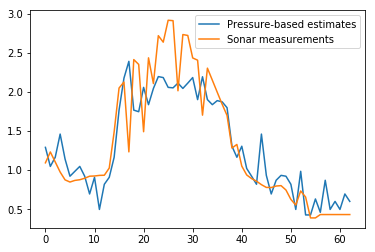

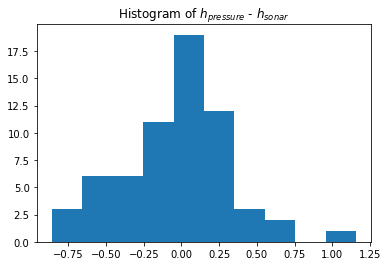

In [19]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# set up a training and testing data set:
training_ratio=0.8
train_ind = int(training_ratio * len(drone_data['pressure']))
training_data = drone_data['pressure'][:train_ind]
training_targets = drone_data['sonar'][:train_ind]
test_data = drone_data['pressure'][train_ind:]
test_targets = drone_data['sonar'][train_ind:]

# train a k-nearest neighbor regressor on the training data and apply it to the test data:
k = 5
kNN = KNeighborsRegressor(n_neighbors = k, weights = 'uniform') # other option for weights = 'distance'
kNN.fit(training_data, training_targets)
test_outputs = kNN.predict(test_data)

# show the results on the test data:
plt.figure()
plt.plot(range(len(test_data)), test_outputs)
plt.plot(range(len(test_data)), test_targets)
plt.legend(['Pressure-based estimates','Sonar measurements'])
    
plt.figure()
plt.hist(test_outputs-test_targets)
plt.title('Histogram of $h_{pressure}$ - $h_{sonar}$')

# We know the variance of the sonar, which we determine with the help of the optitrack system:
training_ground_truth = drone_data['optitrack'][:train_ind]
var_sonar =  np.var(training_targets - training_ground_truth)

# 1. Fuse test_outputs and test_targets based on the observations in the training data:

# 2. Fuse test_outputs and test_targets, using also the optitrack data in the training set:

# 3. Fuse while using the prior on the height:



### Conditions for when fusion is useful in self-supervised learning
In [3], it is studied when fusion of the primary sensor cue and learned sensor cue is useful in self-supervised learning. Besides studying it empirically in a petridish experiment (as you have done above), the conditions under which fusion gives better results was also studied theoretically. Here we will keep using the notation as above, with $P$ and $s$, but the analysis is no longer specific for sonar and pressure measurements. For the model in figure 4, with $t \sim \mathcal{N}(0, \sigma_t^2)$, $P \sim \mathcal{N}(t, \sigma_p^2)$, and $x_s \sim \mathcal{N}(t, \sigma_s^2)$, and assuming that we use linear regression for learning the mapping $f(P) = x_s$, we can derive closed-form equations under which conditions the fused estimate is better than $x_s$ alone. 

The resulting equations are rather lengthy, and can be found in [3]. In short, there are two conditions under which SSL fusion is beneficial. First, the fused estimate is better when $t$ has a strong prior. To understand this case, think of the fact that the machine learning method will actually take the prior into account when learning the mapping $f$: If $x_s$ is often close to 0 since $t$ is often close to 0, the learned mapping will exploit this bias in the data, while using only $x_s$ itself will not. Second, the fused estimate is better when the learned cue is 'sufficiently' informative, i.e., $\sigma_p$ has to be sufficiently small compared to $\sigma_s$. 'Sufficient' is not too restrictive, e.g., in a case studied in [3] where $\sigma_s^2=1$, $\sigma_p^2$ was allowed to be $11.57 \times$ as large.

## Answers

<FONT COLOR="red">Exercise 1.</FONT>

1. We used the following formula to map pressure to height:

In [ ]:
def pressure_to_height(pressure, base_height = 0):
    """ Transform pressure values from a Paparazzi log to height in meters.
        https://en.wikipedia.org/wiki/Barometric_formula
        h = R T ln (P / Pb) / - g M
    """
    
    PPRZ_ISA_GAS_CONSTANT = 8.31447 # R
    PPRZ_ISA_MOLAR_MASS = 0.0289644 # M
    PPRZ_ISA_GRAVITY = 9.80665 # g
    PPRZ_ISA_SEA_LEVEL_TEMP = 288.15 # T
    PPRZ_ISA_SEA_LEVEL_PRESSURE = 101325.0 # P
    PPRZ_ISA_AIR_GAS_CONSTANT = (PPRZ_ISA_GAS_CONSTANT/PPRZ_ISA_MOLAR_MASS)
    PPRZ_ISA_M_OF_P_CONST = (PPRZ_ISA_AIR_GAS_CONSTANT *PPRZ_ISA_SEA_LEVEL_TEMP / PPRZ_ISA_GRAVITY)
    height = PPRZ_ISA_M_OF_P_CONST * np.log(PPRZ_ISA_SEA_LEVEL_PRESSURE / pressure)
    if(base_height != 0):
        height += -np.mean(height) + base_height
    return height

2. Use the following code in the code block of the exercise. If you run it there, you will see that the error oscillates around 92.5 meters. So, the main problem of the pressuremeter is that it has a bias. Often this is determined at startup of the drone, when it is on the ground. In the function ``SSL.plot_drone_data(drone_data)`` in the code of ``SSL_drone_data.py`` the mean of the sonar is actually used for correction of this bias. 

Text(0, 0.5, 'Height error [m]')

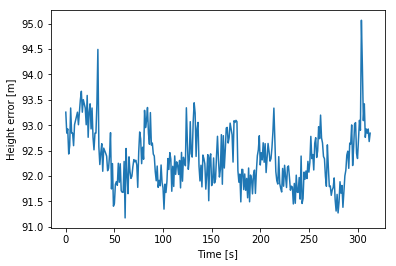

In [3]:
height_pressure = SSL.pressure_to_height(drone_data['pressure'])
plt.figure()
plt.plot(drone_data['optitrack'] - height_pressure)
plt.xlabel('Time [s]')
plt.ylabel('Height error [m]')

3. Use the following code to compare the sonar data with the optitrack ground truth. You will see that the values are centered around 0. Hence, it seems an unbiased estimate.

Text(0, 0.5, 'Height error [m]')

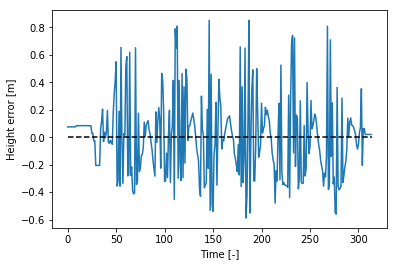

In [6]:
plt.figure()
plt.plot(drone_data['optitrack'] - drone_data['sonar'])
plt.plot([0, len(drone_data['optitrack'])], [0,0], 'k--')
plt.xlabel('Time [-]')
plt.ylabel('Height error [m]')

<FONT COLOR="red">Exercise 2.</FONT>

1. The following code determines the variance and fuses pressure and sonar. You can copy paste it into the code block of the exercise.

In [ ]:
# We base the variance on the training data:
training_outputs = kNN.predict(training_data)
var_pressure = np.var(training_outputs-training_targets)

# Fuse the two measurements according to the first data fusion equation above:
test_fused = (var_sonar * test_outputs + var_pressure * test_targets) / (var_sonar + var_pressure)

MAE_sonar = np.mean(np.abs(test_targets - drone_data['optitrack'][train_ind:]))
MAE_fused = np.mean(np.abs(test_fused - drone_data['optitrack'][train_ind:]))
print(f'MAE sonar = {MAE_sonar}, MAE fused = {MAE_fused}')

2. Paste the following code in the code block of the exercise. If you run it, you will see that the error reduces further, since the variance has been determined with respect to the ground truth target (not the - in itself - noisy sonar).

In [ ]:
# Determine the variance on the optitrack ground truth
var_pressure = np.var(training_outputs-drone_data['optitrack'][:train_ind])

# Fuse the two measurements according to the first data fusion equation above:
test_fused = (var_sonar * test_outputs + var_pressure * test_targets) / (var_sonar + var_pressure)

MAE_fused_GTvar = np.mean(np.abs(test_fused - drone_data['optitrack'][train_ind:]))
print(f'MAE fused with knowledge of variance = {MAE_fused_GTvar}')


3. A naïve application of the second fusion formula with prior (as given in the following code) will give a worse error. The problem is that the fusion formula assumes a target variable centered on 0, which is not the case for our target variable (optitrack height).

In [ ]:
var_t = np.var(training_ground_truth)

test_fused =(var_sonar * test_outputs + var_pressure * test_targets) / (var_sonar + var_pressure + var_t)

MAE_fused_GTvar_prior = np.mean(np.abs(test_fused - drone_data['optitrack'][train_ind:]))
print(f'MAE fused with knowledge of variance with prior on t = {MAE_fused_GTvar_prior}')

## References
[1] Thrun, S., Montemerlo, M., Dahlkamp, H., Stavens, D., Aron, A., Diebel, J., ... & Lau, K. (2006). Stanley: The robot that won the DARPA Grand Challenge. Journal of field Robotics, 23(9), 661-692.

[2] Garg, R., BG, V. K., Carneiro, G., & Reid, I. (2016, October). Unsupervised cnn for single view depth estimation: Geometry to the rescue. In European Conference on Computer Vision (pp. 740-756). Springer, Cham.

[3] de Croon, G. C. H. E. (2017). Self-supervised learning: When is fusion of the primary and secondary sensor cue useful?. <A HREF="https://arxiv.org/abs/1709.08126" TARGET="_blank">arXiv preprint arXiv:1709.08126</A>. 

[4] C.M. Bishop. Pattern recognition and machine learning. Springer Science and Business Media, LLC, New York, NY, 2006.